In this problem, we classify ecg signals from two people. ‘001a.csv’ is from person one, and ‘002a.csv’ is from person two. These two files have the same format, each contains 1,000 measurements per second from 9 sensors. The measurements for these 9 sensors are labeled x, x1, x2, x3, x4, x5, x6, x7, x8. There are 5 minutes of data in total. Therefore, the number of rows in each file is 300,000. The first 200,000 rows of data are used for training and the rest are used for testing.
We train and test our classifier using 1-second segments of the ecg signals.
We use both Conv1D and LSTM models and compare their performances.

In [1]:
import numpy as np
import pandas as pd
get_ipython().magic('matplotlib inline')
import seaborn; seaborn.set()
import matplotlib.pyplot as plt
from tensorflow import keras


from os import listdir
from os.path import isfile, join
mypath = '/Users/weiwei/Downloads/STAFF III DataBase/originalCSV/'

In [2]:
fname ='001a.csv'
file = mypath + fname
data = pd.read_csv(file, header=None)
data = data.dropna()
data.columns = ['tick', 'x', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8']

In [3]:
data.head()

tick         x        x1        x2        x3        x4        x5        x6  \
0   0.0  0.030000 -0.034375 -0.223750  0.025000 -0.081875 -0.146250  0.071250   
1   1.0  0.026250 -0.035625 -0.225000  0.021250 -0.090000 -0.145625  0.075625   
2   2.0  0.028125 -0.034375 -0.225000  0.020000 -0.098125 -0.140625  0.081250   
3   3.0  0.036250 -0.034375 -0.225625  0.020000 -0.097500 -0.138750  0.083125   
4   4.0  0.036250 -0.036875 -0.228750  0.018125 -0.086250 -0.140000  0.078750   

         x7        x8  
0  0.073750  0.000625  
1  0.080000  0.004375  
2  0.083750  0.001875  
3  0.080000 -0.003750  
4  0.071875 -0.008125

In [4]:
data.describe()

tick              x             x1             x2  \
count  300000.000000  300000.000000  300000.000000  300000.000000   
mean      499.500000       0.019820      -0.039967      -0.171953   
std       288.675471       0.170410       0.209809       0.217812   
min         0.000000      -1.057500      -1.580625      -1.673750   
25%       249.750000       0.018750      -0.054375      -0.208125   
50%       499.500000       0.048125      -0.011875      -0.162500   
75%       749.250000       0.090000       0.035000      -0.111875   
max       999.000000       0.235000       0.377500       0.757500   

                  x3             x4             x5             x6  \
count  300000.000000  300000.000000  300000.000000  300000.000000   
mean       -0.003333       0.015396      -0.069176       0.016106   
std         0.278361       0.192723       0.217819       0.105982   
min        -1.526875      -0.438125      -0.419375      -0.288125   
25%        -0.053125      -0.086875      -0.173750      -0.030000   
50%        -0.005000      -0.011875      -0.106250       0.003750   
75%         0.041875       0.075625      -0.034375       0.035000   
max         2.094375       1.471875       1.397500       0.760625   

                  x7             x8  
count  300000.000000  300000.000000  
mean       -0.075709      -0.091822  
std         0.100607       0.087514  
min        -0.435625      -0.646875  
25%        -0.136250      -0.132500  
50%        -0.085000      -0.086250  
75%        -0.027500      -0.041875  
max         0.478750       0.236250

In [5]:
fname ='002a.csv'
file = mypath + fname
data1 = pd.read_csv(file, header=None)
data1 = data1.dropna()
data1.columns = ['tick', 'x', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8']
data1.head()

tick         x        x1        x2        x3        x4        x5        x6  \
0   0.0  0.093125  0.155000  0.071250  0.110625 -0.036875 -0.475625 -0.005625   
1   1.0  0.093750  0.153750  0.071250  0.110000 -0.037500 -0.473750 -0.003750   
2   2.0  0.093125  0.151250  0.069375  0.109375 -0.040625 -0.472500 -0.002500   
3   3.0  0.092500  0.149375  0.067500  0.107500 -0.045000 -0.473125 -0.003750   
4   4.0  0.093750  0.150000  0.066875  0.105625 -0.047500 -0.475000 -0.006250   

         x7        x8  
0 -0.221250 -0.215625  
1 -0.221250 -0.218125  
2 -0.225000 -0.222500  
3 -0.226875 -0.221250  
4 -0.225000 -0.218125

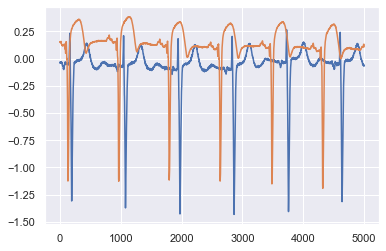

In [6]:
plt.plot(data.x1[:5000]);
plt.plot(data1.x1[:5000]);

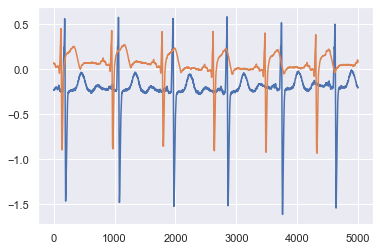

In [7]:
plt.plot(data.x2[:5000]);
plt.plot(data1.x2[:5000]);

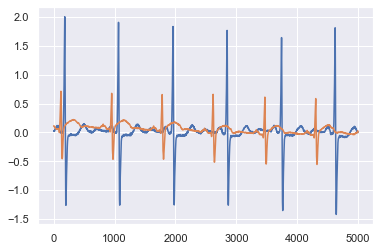

In [8]:
plt.plot(data.x3[:5000]);
plt.plot(data1.x3[:5000]);

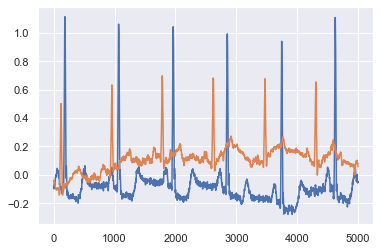

In [9]:
plt.plot(data.x4[:5000]);
plt.plot(data1.x4[:5000]);

In [10]:
float_data = np.array(data)

In [11]:
float_data = float_data[:, 1:]

In [12]:
float_data.shape

(300000, 9)

In [13]:
float_data1 = np.array(data1)
float_data1 = float_data1[:, 1:]
float_data1.shape

(300000, 9)

In [14]:
freq = 1000
def sample(n, duration, data):
    samples = []
    for i in range(n):
        rand = np.random.randint(data.shape[0] - freq*duration)
        samples.append(data[rand: rand+freq*duration, :])
    return np.array(samples)

In [15]:
x_train = sample(2000, 1, float_data[:200000])

In [16]:
x_train.shape

(2000, 1000, 9)

In [17]:
y_train = np.zeros(x_train.shape[0])

In [18]:
y_train

array([0., 0., 0., ..., 0., 0., 0.])

In [19]:
x_train1 = sample(2000, 1, float_data1[:200000])

In [20]:
y_train1 = np.ones(x_train1.shape[0])

In [21]:
y_train1

array([1., 1., 1., ..., 1., 1., 1.])

In [22]:
x_train = np.concatenate((x_train, x_train1), axis=0)

In [23]:
x_train.shape

(4000, 1000, 9)

In [24]:
y_train = np.concatenate((y_train, y_train1), axis=0)

In [25]:
y_train.shape

(4000,)

In [26]:
indices = np.arange(x_train.shape[0])
np.random.shuffle(indices)
x_train = x_train[indices]
y_train = y_train[indices]

In [27]:
x_test = sample(2000, 1, float_data[200000:])
y_test = np.zeros(x_test.shape[0])
x_test1 = sample(2000, 1, float_data1[200000:])
y_test1 = np.ones(x_test1.shape[0])
x_test = np.concatenate((x_test, x_test1), axis=0)
y_test = np.concatenate((y_test, y_test1), axis=0)

In [28]:
from keras import layers
from keras import models

model = models.Sequential()
model.add(layers.Conv1D(32, 5, activation='relu', input_shape=(, )))
model.add(layers.MaxPooling1D())
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(, activation=''))

Using TensorFlow backend.


In [29]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 996, 32)           1472      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 498, 32)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 494, 32)           5152      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               16896     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 513       
Total params: 24,033
Trainable params: 24,033
Non-trainable params: 0
__________________________________________________

In [30]:
from keras import optimizers

model.compile(loss='',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

In [31]:
history = model.fit(x_train, y_train, shuffle=True,
                    epochs=10,
                    batch_size=32,
                    validation_split=0.2)

Train on 3200 samples, validate on 800 samples
Epoch 1/10
3200/3200 [==============================] - 2s 634us/step - loss: 0.4295 - acc: 0.9828 - val_loss: 0.2162 - val_acc: 0.9987
Epoch 2/10
3200/3200 [==============================] - 2s 565us/step - loss: 0.1098 - acc: 0.9972 - val_loss: 0.0326 - val_acc: 0.9987
Epoch 3/10
3200/3200 [==============================] - 2s 565us/step - loss: 0.0154 - acc: 0.9991 - val_loss: 0.0035 - val_acc: 1.0000
Epoch 4/10
3200/3200 [==============================] - 2s 562us/step - loss: 0.0015 - acc: 1.0000 - val_loss: 2.7867e-04 - val_acc: 1.0000
Epoch 5/10
3200/3200 [==============================] - 2s 568us/step - loss: 9.3428e-05 - acc: 1.0000 - val_loss: 1.2267e-05 - val_acc: 1.0000
Epoch 6/10
3200/3200 [==============================] - 2s 537us/step - loss: 3.6878e-06 - acc: 1.0000 - val_loss: 5.1739e-07 - val_acc: 1.0000
Epoch 7/10
3200/3200 [==============================] - 2s 562us/step - loss: 2.1544e-07 - acc: 1.0000 - val_loss: 7.

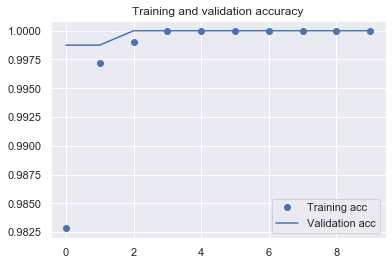

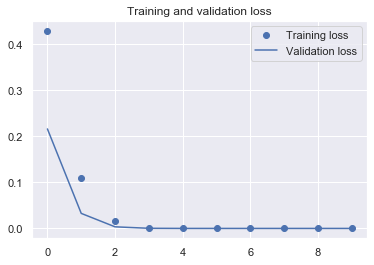

In [32]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [33]:
test_loss, test_acc = model.evaluate(x_test, y_test)

4000/4000 [==============================] - 1s 137us/step


In [34]:
test_acc

1.0

In [35]:
import keras.models
keras.models.save_model(model, 'ecg_Conv1D.h5')

In [36]:
from keras import layers
from keras import models

model = models.Sequential()
model.add(layers.LSTM(32, input_shape=(, )))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(, activation=''))

In [37]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 32)                5376      
_________________________________________________________________
dense_3 (Dense)              (None, 512)               16896     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 513       
Total params: 22,785
Trainable params: 22,785
Non-trainable params: 0
_________________________________________________________________


In [38]:
from keras import optimizers

model.compile(loss='',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])
history = model.fit(x_train, y_train, shuffle=True,
                    epochs=10,
                    batch_size=32,
                    validation_split=0.2)

Train on 3200 samples, validate on 800 samples
Epoch 1/10
3200/3200 [==============================] - 30s 10ms/step - loss: 0.6222 - acc: 0.7881 - val_loss: 0.5383 - val_acc: 0.8350
Epoch 2/10
3200/3200 [==============================] - 30s 9ms/step - loss: 0.4261 - acc: 0.9022 - val_loss: 0.2848 - val_acc: 0.9287
Epoch 3/10
3200/3200 [==============================] - 30s 9ms/step - loss: 0.1740 - acc: 0.9556 - val_loss: 0.1048 - val_acc: 0.9600
Epoch 4/10
3200/3200 [==============================] - 31s 10ms/step - loss: 0.0534 - acc: 0.9866 - val_loss: 0.0161 - val_acc: 1.0000
Epoch 5/10
3200/3200 [==============================] - 29s 9ms/step - loss: 0.0178 - acc: 0.9978 - val_loss: 0.0074 - val_acc: 1.0000
Epoch 6/10
3200/3200 [==============================] - 30s 9ms/step - loss: 0.0077 - acc: 0.9991 - val_loss: 0.0028 - val_acc: 1.0000
Epoch 7/10
3200/3200 [==============================] - 31s 10ms/step - loss: 0.0045 - acc: 0.9994 - val_loss: 0.0010 - val_acc: 1.0000
Epoch

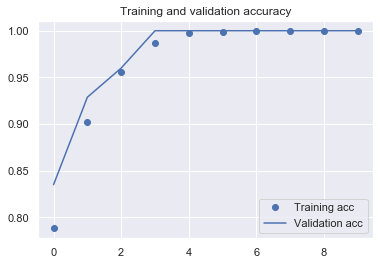

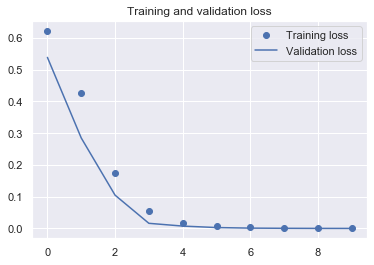

In [39]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [40]:
test_loss, test_acc = model.evaluate(x_test, y_test)

4000/4000 [==============================] - 7s 2ms/step


In [41]:
test_acc

0.9564999938011169

In [42]:
import keras.models
keras.models.save_model(model, 'ecg_LSTM.h5')